### 導入套件

cv2：opencv 是計算機視覺，應用於照片識別人臉標示人名


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### 處理 Dataset

##### 引入 Dataset

將貓狗`img`轉換成`array`放入`data`中，`label`放入 0、1 分別表示貓和狗  
因為訓練用圖片大小不一，所以 Resize 成同一大小

- 機器學習圖片設為灰階的原因：
  - 減少計算量
  - 很多演算法對於顏色的依賴性不強
  - 識別物體關鍵是梯度，彩色的圖片可能會引響梯度的萃取(ex:光照、陰影等)
  - RGB 不能反映圖像的形態特徵(只是在光學的原理上進行顏色調配)，**顏色所能帶來的信息不多**

> 這裡使用 PIL 讀取圖片會報錯 `UnidentifiedImageError`  
> 發現是 Microsoft 給的資料庫中，PetImages/Cat 和 Dog 資料夾分別有一張 0kB 的假照片  
> 把那兩張照片移除，PIL 便可正常讀取  
> 但這邊還是為了方便，使用 cv2 讀取


In [ ]:
import os

dataset_dir = "C:/Users/USER/Desktop/Master_0/ESC_LAB/assignment2/dataset"
train_dir = os.path.join(dataset_dir, "train")
dict_lables = {"cat": 0, "dog": 1}
size = (80, 80)
data = []
label = []

def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = dict_lables[category]
        img = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)  # 圖片轉為灰階
        img_arr = cv2.resize(img, dsize=size)  # 將圖片Resize
        data.append(img_arr)
        label.append(category)


create_test_data(train_dir)

##### 處理圖片

重新定義尺寸和將處理好的陣列儲存，方便下次不用再次處理資料  
資料改變排列順序

In [13]:
import random

data = np.array(data).reshape(-1, 80, 80, 1)
label = np.array(label)
print("data.shape: {}\nlabel.shape: {}".format(data.shape, label.shape))
print(type(data), type(label))

# Normalize Data
data = data / 255.0

#資料重新排序(洗牌)
temp = list(zip(data, label))
random.shuffle(temp)
data, label = zip(*temp)
# 轉換回去array type
data = np.array(data)
label = np.array(label)

# Save array in .npy file
np.save("preprocessed_data", data)
np.save("preprocessed_label", label)

data.shape: (25000, 80, 80, 1)
label.shape: (25000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


#### 切割資料集
切割為訓練集和測試集  
train_test_split() 所接受的變數其實非常單純，基本上為 3 項：『原始的資料』、『Seed』、『比例』  
這邊設定訓練資料80%，測試資料20%  
* 原始的資料：就如同上方的 data 一般，是我們打算切成 Training data 以及 Test data 的原始資料
* Seed： 亂數種子，可以固定我們切割資料的結果
* 比例：可以設定 train_size 或 test_size，只要設定一邊即可，範圍在 [0-1] 之間

In [30]:
import os
from sklearn.model_selection import train_test_split

output_dir = "C:/Users/USER/Desktop/Master_0/ESC_LAB/assignment2/output"

#load .npy file
data = np.load(os.path.join(output_dir, "preprocessed_data.npy"))
label = np.load(os.path.join(output_dir, "preprocessed_label.npy"))

#切割訓練資料集和測試資料集8:2
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=42)

#從測試資料集切割1:1給驗證集
validation_data, test_data, validation_label, test_label = train_test_split(
    test_data, test_label, test_size=0.5, random_state=42)

print("train data shape: {}\ntrain data label shape: {}".format(train_data.shape, train_label.shape))
print("test data shape: {}\ntest data label shape: {}".format(test_data.shape, test_label.shape))

train data shape: (20000, 80, 80, 1)
train data label shape: (20000,)
test data shape: (2500, 80, 80, 1)
test data label shape: (2500,)


### CNN 模型的建立

1. 要先建構神經網路架構，所以要靠 Sequential()來定義


In [31]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=data.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1327168   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

### Run CNN

> 在 Run tensorflow 的 code 時，一直出現 kernel die 的報錯
> 看[官方集合問題](https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes)後  
> [解答](https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes-when-using-tensorflow)
> 重新安裝 tensorflow，就解決問題了

> 要再次訓練的時候發現kernel又掛掉，是[cuDNN版本的問題](https://blog.csdn.net/qq_45071353/article/details/124091856)不相容導致的，改成cuDNN v8.0.5就可以了


In [32]:
train_history = model.fit(train_data, train_label, epochs=10, batch_size=8,
                          validation_data=(validation_data, validation_label), validation_freq=1)

Epoch 1/10
2500/2500 [==============================] - 46s 16ms/step - loss: 0.6689 - accuracy: 0.5704 - val_loss: 0.5344 - val_accuracy: 0.7288
Epoch 2/10
2500/2500 [==============================] - 57s 23ms/step - loss: 0.5207 - accuracy: 0.7441 - val_loss: 0.4881 - val_accuracy: 0.7672
Epoch 3/10
2500/2500 [==============================] - 67s 27ms/step - loss: 0.4285 - accuracy: 0.7989 - val_loss: 0.4541 - val_accuracy: 0.7880
Epoch 4/10
2500/2500 [==============================] - 68s 27ms/step - loss: 0.3430 - accuracy: 0.8475 - val_loss: 0.4862 - val_accuracy: 0.7776
Epoch 5/10
2500/2500 [==============================] - 95s 38ms/step - loss: 0.2531 - accuracy: 0.8927 - val_loss: 0.5376 - val_accuracy: 0.7704
Epoch 6/10
2500/2500 [==============================] - 92s 37ms/step - loss: 0.1581 - accuracy: 0.9369 - val_loss: 0.6456 - val_accuracy: 0.7776
Epoch 7/10
2500/2500 [==============================] - 106s 43ms/step - loss: 0.0864 - accuracy: 0.9691 - val_loss: 0.8979 

### 訓練好的模型和資料儲存


In [34]:
import os

os.chdir('C:/Users/USER/Desktop/Master_0/ESC_LAB/assignment2/output')
history_data = pd.DataFrame.from_dict(train_history.history, orient='index').T
history_data.to_excel('loss_accuracy_data.xlsx', sheet_name='sheet1', index=False)
history_data.to_pickle('loss_accuracy_data.pkl')
model.save("catdog_model.h5")
print(history_data, '\n\n')


       loss  accuracy  val_loss  val_accuracy
0  0.629127   0.63585  0.534392        0.7288
1  0.507190   0.75375  0.488080        0.7672
2  0.428441   0.79830  0.454093        0.7880
3  0.348789   0.84355  0.486237        0.7776
4  0.257028   0.88765  0.537620        0.7704
5  0.169282   0.93005  0.645632        0.7776
6  0.096297   0.96355  0.897934        0.7664
7  0.068234   0.97540  1.070066        0.7576
8  0.047852   0.98400  1.216013        0.7560
9  0.044770   0.98445  1.212647        0.7604 




### 繪製圖表

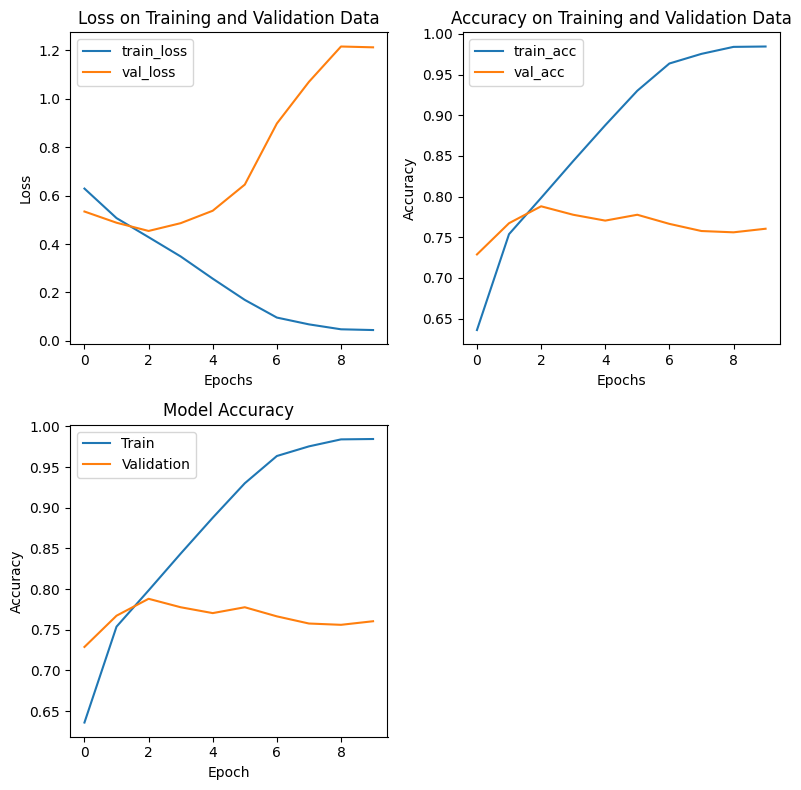

In [60]:
import matplotlib.pyplot as plt

def training_plot(_history):
    loss = _history.history['loss']
    val_loss = _history.history['val_loss']
    acc = _history.history['accuracy']
    val_acc = _history.history['val_accuracy']

    #製作圖表
    fig = plt.figure(figsize=(8, 8)) #建立畫板(8*4英吋)
    # 描繪損失函數
    fig1 = fig.add_subplot(221)  # 一行兩列的第一個
    fig1.plot(loss, label='train_loss')
    fig1.plot(val_loss, label='val_loss')
    fig1.set_xlabel('Epochs')  #設定x軸
    fig1.set_ylabel('Loss')  #設定y軸
    fig1.set_title('Loss on Training and Validation Data')
    fig1.legend() #給圖像加圖例
    # plt.show()



    # # subplot acc
    fig2 = fig.add_subplot(222)
    fig2.plot(acc,label='train_acc')
    fig2.plot(val_acc,label='val_acc')
    fig2.set_xlabel('Epochs')
    fig2.set_ylabel('Accuracy')
    fig2.set_title('Accuracy on Training and Validation Data')
    fig2.legend() #給圖像加圖例


    plt.subplot(223)
    plt.plot(_history.history['accuracy'])
    plt.plot(_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left') #loc設置圖例位置

    plt.tight_layout() #自動保持子圖的正確間距


training_plot(train_history)


### 訓練 History 和資料讀檔


In [9]:
import pandas as pd
import os

os.chdir('C:/Users/USER/Desktop/Master_0/ESC_LAB/assignment2/output')


# 載入pkl檔案
def read_history_pkl():
    train_history = pd.read_pickle("loss_accuracy_data.pkl")
    print(train_history)


read_history_pkl()
# 載入訓練好的模型
model = load_model('catdog_model.h5')
# score = model.evaluate(data, label, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
model.summary()


       loss  accuracy  val_loss  val_accuracy
0  0.637411   0.63375  0.588221        0.7652
1  0.533799   0.73055  1.399651        0.7512
2  0.463602   0.78270       NaN           NaN
3  0.392749   0.82225       NaN           NaN
4  0.306166   0.86810       NaN           NaN
5  0.215993   0.90990       NaN           NaN
6  0.136969   0.94565       NaN           NaN
7  0.094374   0.96385       NaN           NaN
8  0.069323   0.97420       NaN           NaN
9  0.057213   0.97735       NaN           NaN
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        36928     
____________

### 測試模型


In [ ]:
test_dir = os.path.join(os.getcwd(), "dataset", "test1")
test_data = []
id_line = []


def create_test_data(path):
    for f in os.listdir(test_dir):
        id_line.append(f.split(".")[0])
        img = cv2.imread(os.path.join(test_dir, f), cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img, dsize=(80, 80))
        test_data.append(img_arr)


create_test_data(test_dir)
test_data = np.array(test_data).reshape(-1, 80, 80, 1)
test_data = test_data / 255.0

prediction = model.predict(test_data)

In [ ]:
predicted_val = [int(round(p[0])) for p in prediction]
submission_df = pd.DataFrame({'id': id_line, 'label': predicted_val})
submission_df.to_excel("submission.xlsx", sheet_name='sheet1', index=False)
